1. Plotting actual vs predicted using all data (fit NN to all data first)

In [105]:
# Function to split same percent for each unique data in df column
def split_unique(dataset, column, test_size):
  X_train2 = pd.DataFrame()
  X_test2 = pd.DataFrame()
  y_train2 = pd.DataFrame()
  y_test2 = pd.DataFrame()
  for i,C in enumerate(dataset[column].unique()):
    X = dataset[dataset[column] == C][['bldgname',
                                    'Air Temp', 
                                    'Abs Hum',
                                    'DSW Top', 
                                    'DSW North', 
                                    'DSW South', 
                                    'DSW East', 
                                    'DSW West', 
                                    'Shade North', 
                                    'Shade East', 
                                    'Shade West',
                                    'Shade South']]
    y = dataset[dataset[column] == C]['CHWTON/SQFT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
    X_train2 = X_train2.append(X_train)
    X_test2 = X_test2.append(X_test)
    y_train2 = y_train2.append(y_train)
    y_test2 = y_test2.append(y_test)
  return X_train2, X_test2, y_train2, y_test2

# Split microclimate data 20% from each building for testing
X_train2, X_test2, y_train2, y_test2 = split_unique(MicroclimateData, 'bldgname', 0.2)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)

# Check number of points in each building
# Note: Biodesign C has less data than all other buildings in original data
# for i,C in enumerate(MicroclimateData['bldgname'].unique()):
#   print(C, ":", len(MicroclimateData[MicroclimateData['bldgname']==C]))

(7668, 12)
(11, 7668)
(1921, 12)


## Flow of Code:
#### 1. Read both datasets, and do data preparation: Scaling, One-hot Encoding
#### 2. For limited data, train  model on Temp, Hum, Dsw(4), Shade(4), Encoding input features (find hyperparameters analytically)
#### 3. For big data, train model on Temp, Hum, Encoding 
#### 4. Fine tune weather station model on microclimate data and compare performance
#### 5. Work on adding artificial features and dropout on microclimate model

In [110]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
tensorboard.__version__

'2.4.0'

In [121]:
class NeuralNetwork():
    def __init__(self,activation_type, hidden_layers, loss, kernel_initializer, bias_initializer, data_type,epochs):
        self.activation_type = activation_type
        self.hidden_layers = hidden_layers
        self.loss = loss
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer 
        self.data_type = data_type
        self.epochs = epochs

    def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
        
    def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
        return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))
    # Function to split same percent for each unique data in df column
    def split_unique(dataset, column, data_columns, test_size):
        X_train2 = pd.DataFrame()
        X_test2 = pd.DataFrame()
        y_train2 = pd.DataFrame()
        y_test2 = pd.DataFrame()
        for i,C in enumerate(dataset[column].unique()):
            X = dataset[dataset[column] == C][data_columns]
            y = dataset[dataset[column] == C]['CHWTON/SQFT']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
            X_train2 = X_train2.append(X_train)
            X_test2 = X_test2.append(X_test)
            y_train2 = y_train2.append(y_train)
            y_test2 = y_test2.append(y_test)
        return X_train2, X_test2, y_train2, y_test2
        
    def prepare_data(self, dataset, func):        
        #add artificial features
        dataset['Air Temp Squared'] =  dataset['Air Temp']**2
        dataset['Abs Hum Squared'] =  dataset['Abs Hum']**2
        dataset['Air Temp*Abs Hum'] =  dataset['Air Temp']* dataset['Abs Hum']
        MicroclimateData['Air Temp Squared'] =  MicroclimateData['Air Temp']**2
        MicroclimateData['Abs Hum Squared'] =  MicroclimateData['Abs Hum']**2
        MicroclimateData['Air Temp*Abs Hum'] =  MicroclimateData['Air Temp']* MicroclimateData['Abs Hum']
        if self.data_type == 'WeatherStation'  and (func == 'test' or func == 'train'):
            X = dataset[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = dataset['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'train':
            X = MicroclimateData[['bldgname',
                                  'Air Temp', 
                                  'Abs Hum',
                                  'Air Temp Squared',
                                  'Abs Hum Squared',
                                  'Air Temp*Abs Hum',
                                  'DSW Top', 
                                  'DSW North', 
                                  'DSW South', 
                                  'DSW East', 
                                  'DSW West', 
                                  'Shade North', 
                                  'Shade East', 
                                  'Shade West',
                                  'Shade South']]
            columns = ['Air Temp', 'Abs Hum', 'Air Temp Squared',
                        'Abs Hum Squared', 'Air Temp*Abs Hum', 'DSW Top',
                       'DSW North', 'DSW South', 'DSW East','DSW West',
                       'Shade North', 'Shade East', 'Shade West', 'Shade South',]
            Y = MicroclimateData['CHWTON/SQFT']
        if self.data_type == 'Microclimate' and func == 'test':
            X = MicroclimateData[['bldgname',
                        'Air Temp', 
                        'Abs Hum',
                        'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']]
            columns = ['Air Temp', 'Abs Hum',
                       'Air Temp Squared',
                        'Abs Hum Squared',
                        'Air Temp*Abs Hum']
            Y = MicroclimateData['CHWTON/SQFT']
        Y = Y.values.reshape(-1, 1)
        StdSc1 = StandardScaler()
        Y = StdSc1.fit_transform(Y)
        X = pd.get_dummies(X)
        StdSc2 = StandardScaler()
        X[columns] = StdSc2.fit_transform(X[columns])
#         X_train, X_test, y_train, y_test = self.split_unique(X, 'bldgname', columns, 0.2)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, 
                                                            random_state=20)
        return X_train, X_test, y_train, y_test
    def define_model(self):
        if self.data_type == 'WeatherStation' :
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(20, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(30, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=16, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))           
        if self.data_type == 'Microclimate':
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=25, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(50, activation = self.activation_type))
                model.add(Dropout(0.2))
                model.add(Dense(1, activation = 'linear'))
        model.compile( loss = self.loss, 
                      optimizer = 'adam')
        model.summary()
        return model
    def train(self, dataset):
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'train')
        self.model = self.define_model()
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
    def fine_tune(self, dataset):
        self.model.trainable = True
        fine_tune_at = 2
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable =  False
        self.model.compile(loss=self.loss, 
                           optimizer='adam')
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'test')
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
        
        
    def plot_curve(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    def evaluate(self, dataset, data_type ):
        call_type = 'test'
        if data_type == self.data_type:
            call_type = 'train'
        _, X_test, _, y_test = self.prepare_data(dataset,call_type)
        Y_preds = self.model.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
        R2_score = metrics.r2_score(y_test, Y_preds)
        print("The RMSE score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", RMSE) 
        print("The R2 score for test dataset of "+ data_type +" on model type:" + self.data_type + " model " +" is:", R2_score)
        return Y_preds, y_test, X_test 

In [122]:
MicroclimateData = pd.read_csv('./Data/all_buildings_limited.csv')
WeatherStationData = pd.read_csv('./Data/all_buildings_big.csv')
if __name__ == "__main__":
    # Train microclimate Model
    MicroclimateModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 250)
    MicroclimateModel.train(MicroclimateData)
    Y_preds, y_test, X_test = MicroclimateModel.evaluate(MicroclimateData, 'Microclimate')
    # Train Weather Station Model
    WeatherStationModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
    WeatherStationModel.train(WeatherStationData)
    _,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')
    # Fine Tune and compare results
    WeatherStationModel.fine_tune(MicroclimateData)
    WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
    _,_,_ = WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 30)                780       
_________________________________________________________________
dense_181 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_182 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_183 (Dense)            (None, 50)                2050      
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_184 (Dense)            (None, 1)                 51        
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
___________________________________________________

2021-11-04 05:51:19.878370: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:51:19.878409: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-11-04 05:51:20.292303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:51:20.292382: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-04 05:51:20.313557: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 05:51:20.314842: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211104-055119/train/plugins/profile/2021_11_04_05_51_20
2021-11-04 05:51:20.315488: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211104-055119/train/plugins/profile/2021_11_04_05_51_20/biswas.trace.json.gz
2021-11-04 05:51:20.316281: I tensorflow/core/profiler/rpc/client/save_profile.c

The RMSE score for test dataset of Microclimate on model type:Microclimate model  is: 0.13663501396400898
The R2 score for test dataset of Microclimate on model type:Microclimate model  is: 0.9807330794331149
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 30)                510       
_________________________________________________________________
dense_186 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_187 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_188 (Dense)            (None, 50)                2050      
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
__________________________________________

2021-11-04 05:51:33.067997: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:51:33.068044: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-11-04 05:51:33.535867: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:51:33.535924: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-04 05:51:33.562457: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 05:51:33.564136: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211104-055133/train/plugins/profile/2021_11_04_05_51_33
2021-11-04 05:51:33.564866: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211104-055133/train/plugins/profile/2021_11_04_05_51_33/biswas.trace.json.gz
2021-11-04 05:51:33.565910: I tensorflow/core/profiler/rpc/client/save_profile.c

The RMSE score for test dataset of WeatherStation on model type:WeatherStation model  is: 0.24710897004521543
The R2 score for test dataset of WeatherStation on model type:WeatherStation model  is: 0.9389450634257822


2021-11-04 05:53:50.919165: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:53:50.919219: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-11-04 05:53:51.263451: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:53:51.263505: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-04 05:53:51.284726: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 05:53:51.286437: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211104-055350/train/plugins/profile/2021_11_04_05_53_51
2021-11-04 05:53:51.286981: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211104-055350/train/plugins/profile/2021_11_04_05_53_51/biswas.trace.json.gz
2021-11-04 05:53:51.287755: I tensorflow/core/profiler/rpc/client/save_profile.c

The RMSE score for test dataset of Microclimate on model type:WeatherStation model  is: 0.15902964496166058
The R2 score for test dataset of Microclimate on model type:WeatherStation model  is: 0.9738997615764454
The RMSE score for test dataset of WeatherStation on model type:WeatherStation model  is: 0.5027949908688774
The R2 score for test dataset of WeatherStation on model type:WeatherStation model  is: 0.747229930418746


Use this to return dummy variables to original columns example: df2 = undummify(df2) 

In [ ]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

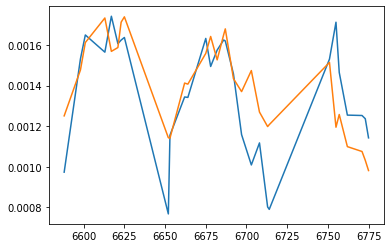

In [144]:
# Sample of how plotting can be performed, need to do this by day
time = MicroclimateData[['Date_Time','Month','Day','Hour','Minute']]
results = undummify(X_test)
col = results.pop('bldgname')
results.insert(0, 'bldgname', col)
results['Actual'] = StdSc1.inverse_transform(y_test)
results['Predicted'] = StdSc1.inverse_transform(Y_preds)
results[results['bldgname'] == 'Bulldog Hall']
results = results.join(time)
bldg = results[results['bldgname']=='Bulldog Hall']
month = bldg[bldg['Month'] == 8]
z = month.sort_values(by=['Month', 'Day', 'Hour', 'Minute'])
plt.plot(z['Actual'])
plt.plot(z['Predicted'])
plt.show()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 30)                510       
_________________________________________________________________
dense_166 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_167 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_168 (Dense)            (None, 50)                2050      
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 51        
Total params: 5,491
Trainable params: 5,491
Non-trainable params: 0
___________________________________________________

2021-11-04 05:44:57.814554: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:44:57.814596: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-11-04 05:44:58.210489: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:44:58.210551: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-04 05:44:58.230915: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 05:44:58.232220: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211104-054457/train/plugins/profile/2021_11_04_05_44_58
2021-11-04 05:44:58.232834: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211104-054457/train/plugins/profile/2021_11_04_05_44_58/biswas.trace.json.gz
2021-11-04 05:44:58.233667: I tensorflow/core/profiler/rpc/client/save_profile.c

The RMSE score for test dataset of WeatherStation is: 0.24418327579058335
The R2 score for test dataset of WeatherStation is: 0.9403822482139685


ValueError: not enough values to unpack (expected 4, got 3)

In [57]:
# Train Weather Station Model
WeatherStationModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
WeatherStationModel.train(WeatherStationData)
_,_,_,_ = WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_96 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_97 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_98 (Dense)             (None, 50)                2050      
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 51        
Total params: 5,491
Trainable params: 5,491
Non-trainable params: 0
___________________________________________________

2021-11-04 05:11:13.193926: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:11:13.193980: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-11-04 05:11:13.575466: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:11:13.575670: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-04 05:11:13.612607: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 05:11:13.614011: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211104-051113/train/plugins/profile/2021_11_04_05_11_13
2021-11-04 05:11:13.614754: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211104-051113/train/plugins/profile/2021_11_04_05_11_13/biswas.trace.json.gz
2021-11-04 05:11:13.616241: I tensorflow/core/profiler/rpc/client/save_profile.c

The RMSE score for test dataset of Microclimate is: 0.4813894929584201
The R2 score for test dataset of Microclimate is: 0.7608438740749964


(array([[-0.7307279],
        [ 1.3803476],
        [ 1.1643488],
        ...,
        [ 1.2771429],
        [ 2.2634912],
        [ 0.0895946]], dtype=float32),
 array([[-1.03161955],
        [ 1.6855848 ],
        [ 1.43416925],
        ...,
        [ 1.88257945],
        [ 1.28510908],
        [-0.15253571]]),
       Air Temp   Abs Hum  Air Temp Squared  Abs Hum Squared  Air Temp*Abs Hum  \
 6775  0.275443 -0.186465          0.221581        -0.316847         -0.102574   
 5612  1.235027 -0.805584          1.317948        -0.711306         -0.506151   
 5922  0.798287  0.264034          0.803087         0.053147          0.488231   
 5293  0.567240 -1.102149          0.541433        -0.853499         -0.921492   
 1910  1.000088 -0.757436          1.037690        -0.685362         -0.500589   
 ...        ...       ...               ...              ...               ...   
 7845 -0.125959 -1.155272         -0.199077        -0.875771         -1.073971   
 2222  1.391057  1.137430    

In [56]:
# Fine Tune and compare results
WeatherStationModel.fine_tune(MicroclimateData)
WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')

2021-11-04 05:10:23.059079: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:10:23.059133: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-11-04 05:10:23.401654: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-04 05:10:23.401701: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-11-04 05:10:23.423532: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-11-04 05:10:23.424791: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit/20211104-051023/train/plugins/profile/2021_11_04_05_10_23
2021-11-04 05:10:23.425382: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit/20211104-051023/train/plugins/profile/2021_11_04_05_10_23/biswas.trace.json.gz
2021-11-04 05:10:23.426338: I tensorflow/core/profiler/rpc/client/save_profile.c

The RMSE score for test dataset of Microclimate is: 0.15781055781774708
The R2 score for test dataset of Microclimate is: 0.9742983854727494
The RMSE score for test dataset of WeatherStation is: 0.5046609817374317
The R2 score for test dataset of WeatherStation is: 0.7453502701859536


(array([[-0.27365097],
        [-1.1841555 ],
        [-0.11740661],
        ...,
        [-0.8040029 ],
        [ 0.36976367],
        [-1.0261501 ]], dtype=float32),
 array([[-0.08406833],
        [-0.84752508],
        [ 0.14039772],
        ...,
        [-0.91756198],
        [ 0.66086221],
        [-0.73521282]]),
         Air Temp   Abs Hum  Air Temp Squared  Abs Hum Squared  \
 186789  0.224833 -0.517549          0.043167        -0.551818   
 32371  -1.041248  0.649426         -1.007956         0.346841   
 71192   0.857873 -0.865957          0.793970        -0.698230   
 142975  1.596421  1.662780          1.859692         1.637273   
 75461   1.279900  1.693355          1.377927         1.683577   
 ...          ...       ...               ...              ...   
 33901  -1.674288 -0.451287         -1.308277        -0.517629   
 169178  0.330340 -0.853711          0.157873        -0.694034   
 191220 -1.674288 -0.274424         -1.308277        -0.416447   
 324500  0.013819  